In [1]:
# import librraires
%matplotlib inline
from IPython.display import Image, HTML
import json
import datetime
import ast
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from wordcloud import WordCloud, STOPWORDS

sns.set_style('whitegrid')
sns.set(font_scale=1.25)
pd.set_option('display.max_colwidth', 50)

In [2]:
df=pd.read_csv('../data/movies_metadata_cleaned.csv')

In [3]:
df.head()

,Unnamed: 0,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,overview,popularity,...,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count,return,year
0,0,"{'name': 'Toy Story Collection', 'poster_path'...",30000000.0,"[{'name': 'Animation', 'id': 16}, {'name': 'Co...",http://toystory.disney.com/toy-story,862,tt0114709,en,"Led by Woody, Andy's toys live happily in his ...",52.706,...,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.9,12976,12.451801,1995
1,1,"{'name': 'Jumanji Collection', 'poster_path': ...",65000000.0,"[{'name': 'Adventure', 'id': 12}, {'name': 'Fa...",http://www.sonypictures.com/movies/jumanji/,8844,tt0113497,en,When siblings Judy and Peter discover an encha...,8.122,...,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,7.2,7583,4.043035,1995
2,2,"{'name': 'Grumpy Old Men Collection', 'poster_...",NaN,"[{'name': 'Romance', 'id': 10749}, {'name': 'C...",NaN,15602,tt0113228,en,A family wedding reignites the ancient feud be...,9.838,...,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.6,212,NaN,1995
3,3,NaN,16000000.0,"[{'name': 'Comedy', 'id': 35}, {'name': 'Drama...",NaN,31357,tt0114885,en,"Cheated on, mistreated and stepped on, the wom...",6.378,...,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.2,78,5.090760,1995
4,4,"{'name': 'Father of the Bride Collection', 'po...",NaN,"[{'name': 'Comedy', 'id': 35}]",NaN,11862,tt0113041,en,Just when George Banks has recovered from his ...,14.706,...,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,6.2,435,NaN,1995


## title ad overview wordclouds
Are there certain words that are more often in Movie Titles and Movie Blurbs? I suspect there are some words which are considered more potent and considered more worthy of a title. Let us find out!

In [4]:
df['title'] = df['title'].astype('str')
df['overview'] = df['overview'].astype('str')

In [5]:
title_corpus=' '.join(df['title'])
overview_corpus=" ".join(df['overview'])

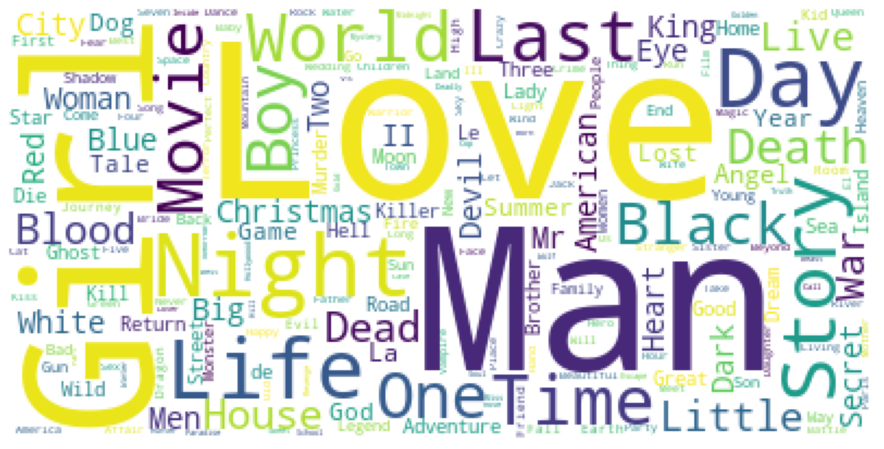

In [6]:
title_wordcloud=WordCloud(stopwords=STOPWORDS,background_color='white').generate(title_corpus)
plt.figure(figsize=(16,8))
plt.imshow(title_wordcloud)
plt.axis('off')
plt.show()

The word <b>Love</b> is the most commonly used word in movie titles. <b>Girl</b> and <b>Man</b> are also among the most commonly occuring words. I think this encapsulates the idea of the ubiquitious presence of romance in movies pretty well.

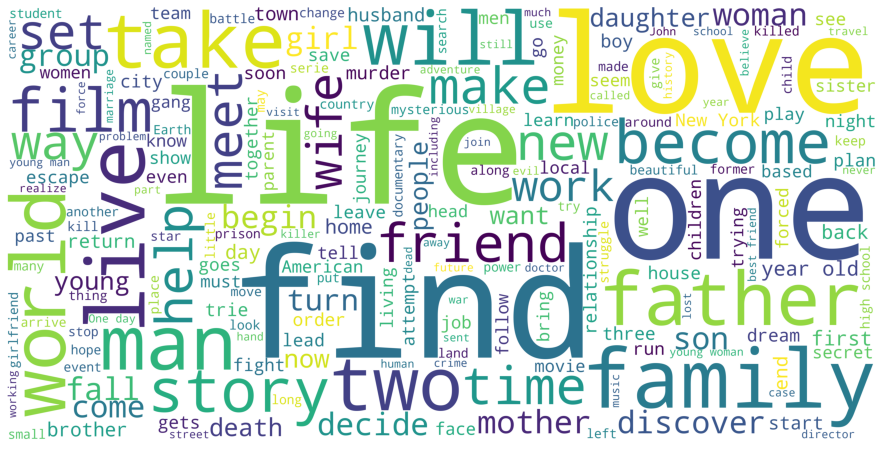

In [7]:
overview_wordcloud = WordCloud(stopwords=STOPWORDS, background_color='white', height=2000, width=4000).generate(overview_corpus)
plt.figure(figsize=(16,8))
plt.imshow(overview_wordcloud)
plt.axis('off')
plt.show()

<b>Life</b> is the most commonly used word in Movie overviews. One and Find are also popular in Movie Blurbs. Together with <b>Love, world, take, family, father,live </b> these wordclouds give us a pretty good idea of the most popular themes present in movies.

## Production Countries
The Full MovieLens Dataset consists of movies that are overwhelmingly in the English language (more than 31000). However, these movies may have shot in various locations around the world. It would be interesting to see which countries serve as the most movies were shot.

In [8]:
df['production_countries'] = df['production_countries'].fillna('[]').apply(ast.literal_eval)
df['production_countries'] = df['production_countries'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [9]:
s = df.apply(lambda x: pd.Series(x['production_countries']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'countries'

C:\Users\kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [10]:
con_df = df.drop('production_countries', axis=1).join(s)
con_df = pd.DataFrame(con_df['countries'].value_counts())
con_df['country'] = con_df.index
con_df.columns = ['num_movies', 'country']
con_df = con_df.reset_index().drop('index', axis=1)
con_df.head(10)

,num_movies,country
0,28453,United States of America
1,5514,France
2,5468,United Kingdom
3,3353,Italy
4,3088,Germany
5,2525,Canada
6,2240,Japan
7,1552,India
8,1537,Spain
9,1435,Russia


Unsurprisingly, the <b>United States</b> is the most popular destination of production for movies given that our dataset largely consists of English movies. Europe is also an extremely popular location with the UK, France, Germany and Italy in the top 5. Japan and India are the most popular Asian countries when it comes to movie production

## Franchise movies

Let us now have a brief look at Franchise movies. 

In [11]:
df_fran = df[df['belongs_to_collection'].notnull()]
df_fran['belongs_to_collection'] = df_fran['belongs_to_collection'].apply(ast.literal_eval).apply(lambda x: x['name'] if isinstance(x, dict) else np.nan)
df_fran = df_fran[df_fran['belongs_to_collection'].notnull()]

C:\Users\kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [12]:
fran_pivot = df_fran.pivot_table(index='belongs_to_collection', values='revenue', aggfunc={'revenue': ['mean', 'sum', 'count']}).reset_index()

### Highest Grossing Movie Franchise

In [13]:
fran_pivot.sort_values('sum', ascending=False).head(10)

,belongs_to_collection,count,mean,sum
1763,The Avengers Collection,4,1.942250e+09,7.769002e+09
1655,Star Wars Collection,8,9.638722e+08,7.710977e+09
749,Harry Potter Collection,8,9.633598e+08,7.706879e+09
875,James Bond Collection,26,2.854196e+08,7.420909e+09
1869,The Fast and the Furious Collection,8,6.417371e+08,5.133897e+09
914,Jurassic Park Collection,5,9.765385e+08,4.882693e+09
2179,Transformers Collection,6,8.078794e+08,4.847276e+09
1358,Pirates of the Caribbean Collection,5,9.044493e+08,4.522247e+09
2174,Toy Story Collection,7,5.902782e+08,4.131947e+09
1160,Mission: Impossible Collection,6,5.950050e+08,3.570030e+09


The <b>Avenger Collection</b> Franchise is the most successful movie franchise raking in more than 7.769 billion dollars from 4 movies. The <b>Star Wars Movies</b> come in a close second with a 7.71 billion dollars from 8 movies. <b>Harry Potter collection</b> is third.

## Production Companies

In [14]:
df['production_companies'] = df['production_companies'].fillna('[]').apply(ast.literal_eval)
df['production_companies']=df['production_companies'].apply(lambda x: [i['name'] for i in x] if isinstance(x,list) else [])

In [15]:
df['production_companies'].head()

0                                              [Pixar]
1    [TriStar Pictures, Interscope Communications, ...
2              [Lancaster Gate, Warner Bros. Pictures]
3                                   [20th Century Fox]
4         [Touchstone Pictures, Sandollar Productions]
Name: production_companies, dtype: object

In [16]:
s = df.apply(lambda x: pd.Series(x['production_companies']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'companies'
s.head()

C:\Users\kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


0                        Pixar
1             TriStar Pictures
1    Interscope Communications
1                 Teitler Film
1                Sony Pictures
Name: companies, dtype: object

In [17]:
com_df = df.drop('production_companies', axis=1).join(s)

In [18]:
com_df['companies'].head()

0                        Pixar
1             TriStar Pictures
1    Interscope Communications
1                 Teitler Film
1                Sony Pictures
Name: companies, dtype: object

In [19]:
com_sum = pd.DataFrame(com_df.groupby('companies')['revenue'].sum().sort_values(ascending=False))
com_sum.columns = ['Total']
com_mean = pd.DataFrame(com_df.groupby('companies')['revenue'].mean().sort_values(ascending=False))
com_mean.columns = ['Average']
com_count = pd.DataFrame(com_df.groupby('companies')['revenue'].count().sort_values(ascending=False))
com_count.columns = ['Number']

com_pivot = pd.concat((com_sum, com_mean, com_count), axis=1)

### Highest earning production movies
Let us find out which production companies have earned the most money from the movie making business.

In [20]:
com_pivot.sort_values('Total',ascending=False).head(10)

,Total,Average,Number
Warner Bros. Pictures,7.877423e+10,1.306372e+08,603
Universal Pictures,6.873347e+10,1.180987e+08,582
20th Century Fox,6.204813e+10,1.442980e+08,430
Paramount,5.438002e+10,1.197798e+08,454
Walt Disney Pictures,5.157496e+10,2.515852e+08,205
Columbia Pictures,4.972716e+10,1.132737e+08,439
New Line Cinema,2.619170e+10,1.128953e+08,232
Sony Pictures,2.597063e+10,1.967472e+08,132
Marvel Studios,2.302783e+10,9.211130e+08,25
DreamWorks Pictures,1.848143e+10,1.727236e+08,107


<b>Warner Bros</b> is the highest earning production company of all time earning a staggering 78.7 billion dollars from close to 600 movies. <b>Universal Pictures</b> and <b>20th Century Fox</b> are the second and the third highest earning companies with 68 billion dollars and 62 billion dollars in revenue respectively.

### Number of movies produced by companies

In [21]:
com_pivot.sort_values('Number', ascending=False).head(10)

,Total,Average,Number
Warner Bros. Pictures,7.877423e+10,1.306372e+08,603
Universal Pictures,6.873347e+10,1.180987e+08,582
Paramount,5.438002e+10,1.197798e+08,454
Columbia Pictures,4.972716e+10,1.132737e+08,439
20th Century Fox,6.204813e+10,1.442980e+08,430
Metro-Goldwyn-Mayer,1.796591e+10,6.485889e+07,277
New Line Cinema,2.619170e+10,1.128953e+08,232
Canal+,7.711713e+09,3.743550e+07,206
Walt Disney Pictures,5.157496e+10,2.515852e+08,205
Touchstone Pictures,1.511490e+10,8.787734e+07,172


<b>Warner Bros. Pictures</b> produced the most number of movies. That is not surprising as it is also the highest earning production company. Fallowed by Universal Pictures and Pramount

## Original language
In this section, let us look at the languages of the movies in our dataset. From the production countries. we have already deduced that the majority of the movies in the dataset are English. Let us see what the other major languages represented are.

In [22]:
df['original_language'].nunique()

111

In [23]:
lang_df=pd.DataFrame(df['original_language'].value_counts())
lang_df['language']=lang_df.index
lang_df.columns=['number','language']
lang_df.head()

,number,language
en,40556,en
fr,3620,fr
it,2488,it
ja,1938,ja
es,1758,es


There are over 111 languages represented in our dataset. As we had expected, English language films form the overwhelmingly majority. French and Italian movies come at a very distant second and third respectively. Let us represent the most popular languages (apart from English) in the form of a bar plot.

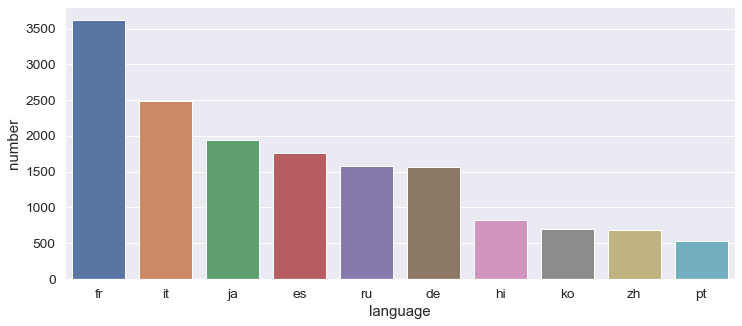

In [24]:

plt.figure(figsize=(12,5))
sns.barplot(x='language', y='number', data=lang_df.iloc[1:11])
plt.show()

## Popularity, vote average and vote count
In this section, we will work with metrics provided to us by TMDB users. We will try to gain a deeper understanding of the popularity, vote average and vote count features and try and deduce any relationships between them as well as other numeric features such as budget and revenue.

In [25]:
def clean_numeric(x):
    try:
        return float(x)
    except:
        return np.nan

In [26]:
df['popularity'] = df['popularity'].apply(clean_numeric).astype('float')
df['vote_count'] = df['vote_count'].apply(clean_numeric).astype('float')
df['vote_average'] = df['vote_average'].apply(clean_numeric).astype('float')

In [27]:
df['popularity'].describe()

count    61768.000000
mean         5.884324
std          7.543025
min          0.600000
25%          2.125000
50%          3.900000
75%          6.871000
max        276.585000
Name: popularity, dtype: float64

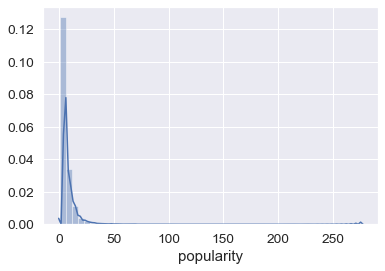

In [28]:
sns.distplot(df['popularity'].fillna(df['popularity'].median()))
plt.show()

The Popularity score seems to be an extremely skewed quantity with a mean of only 25.88 but maximum values reaching as high as 276.

### Most popular movies by popularity scores

In [29]:
df[['title','popularity','year']].sort_values('popularity',ascending=False).head(10)

,title,popularity,year
60365,Joker,276.585,2019
61164,Frozen II,254.871,2019
24872,Avengers: Infinity War,186.028,2018
48428,Coco,175.899,2017
24873,Avengers: Endgame,175.451,2019
59137,Toy Story 4,172.156,2019
59895,Fast & Furious Presents: Hobbs & Shaw,171.262,2019
59213,Spider-Man: Far from Home,160.677,2019
58815,Monos,151.866,2019
59768,The Lion King,146.603,2019


<b>Joker</b>. is the most popular movie by the TMDB Popularity Score. Frozen II and Avengers:Infinity War movies come in second and third respectively.

In [30]:
df['vote_count'].describe()

count    61768.000000
mean       209.478047
std        980.824533
min          0.000000
25%          5.000000
50%         15.000000
75%         56.000000
max      27268.000000
Name: vote_count, dtype: float64

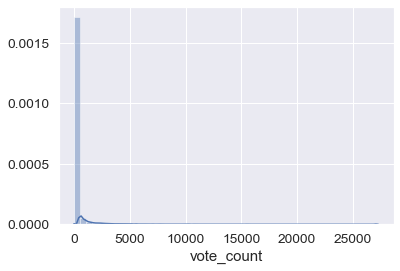

In [31]:
sns.distplot(df['vote_count'])
plt.show()

Compated with popularity scores, the distribution of vote counts is extremely skewed with the median vote count standing at a paltry 15 votes. The most votes a single movie has got stands at 27,268. TMDB Votes, therefore, are not as potent and suggestive as its IMDB Counterpart. Nevertheless, let us check which the most voted on movies on the website are.

### Most voted movies

In [32]:
df[['title','vote_count','year']].sort_values('vote_count',ascending=False).head(10)

,title,vote_count,year
14909,Inception,27268.0,2010
21059,Interstellar,23833.0,2014
24869,Deadpool,23641.0,2016
12227,The Dark Knight,23385.0,2008
17019,The Avengers,23224.0,2012
14088,Avatar,22112.0,2009
21786,Guardians of the Galaxy,21250.0,2014
2908,Fight Club,20162.0,1999
24872,Avengers: Infinity War,19819.0,2018
352,Pulp Fiction,19623.0,1994


<b>Inception and Interstellar </b>, two critically acclaimed and commercially successful Christopher Nolan movies figure at the top of our chart.

In [33]:
df['vote_average'] = df['vote_average'].replace(0, np.nan)
df['vote_average'].describe()

count    59623.000000
mean         6.102967
std          1.201329
min          0.500000
25%          5.400000
50%          6.200000
75%          6.900000
max         10.000000
Name: vote_average, dtype: float64

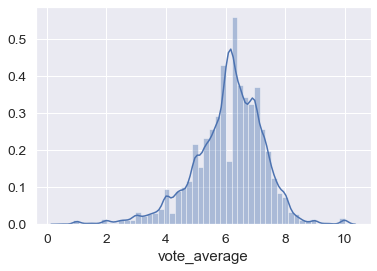

In [34]:
sns.distplot(df['vote_average'].fillna(df['vote_average'].median()))

In [35]:
df[df['vote_count'] > 2000][['title', 'vote_average', 'vote_count' ,'year']].sort_values('vote_average', ascending=False).head(10)

,title,vote_average,vote_count,year
374,The Shawshank Redemption,8.7,17226.0,1994
895,The Godfather,8.7,13050.0,1972
10196,Dilwale Dulhania Le Jayenge,8.7,2380.0,1995
582,Schindler's List,8.6,10378.0,1993
1243,The Godfather: Part II,8.6,7739.0,1974
41708,Your Name.,8.6,6406.0,2016
2276,Life Is Beautiful,8.5,9317.0,1997
3095,The Green Mile,8.5,11011.0,1999
12227,The Dark Knight,8.5,23385.0,2008
59464,Parasite,8.5,9330.0,2019


<b>The Shawshank Redemption</b> and <b>The Godfather</b> are the two most critically acclaimed movies in the TMDB Database. Interestingly, they are the top 2 movies in IMDB's Top 250 Movies list too. 

Do popularity and vote average share a tangible relationship? In other words, is there a strong positive correlation between these two quanitties? Let us visualise their relationship in the form of a scatterplot.

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


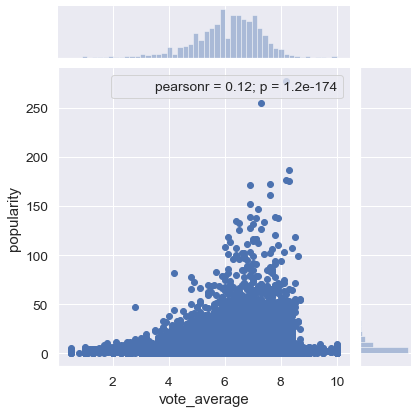

In [36]:
j=sns.jointplot(x='vote_average', y='popularity', data=df)
j.annotate(stats.pearsonr)
plt.show()

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


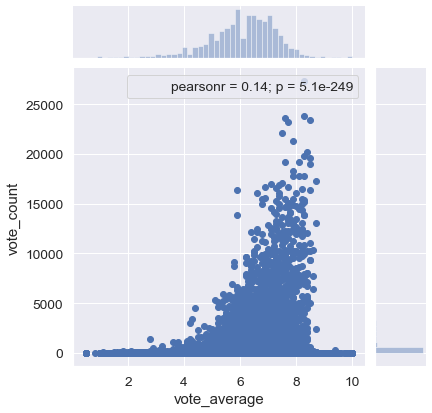

In [37]:
j=sns.jointplot(x='vote_average', y='vote_count', data=df)
j.annotate(stats.pearsonr)
plt.show()

- There is a very minute correlation between Popularity and Vote Average. A large number of votes on a particular movie does not necessarily imply that movie is popular
- There is a very small correlation between Vote Count and Vote Average. A large number of votes on a particular movie does not necessarily imply that the movie is good.

## Movie Release Dates

Release Dates can often play a very important role in determining the success and the revenue generated by a particular movie. In this section, we will try and gain insights about release dates in terms of years, months and days of the week.

We have already constructed the year feature in our preliminary data wrangling step. Let us now extract the month and day too for each movie with a release date.

In [38]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [39]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [40]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-'))    
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [41]:
df['day'] = df['release_date'].apply(get_day)
df['month'] = df['release_date'].apply(get_month)

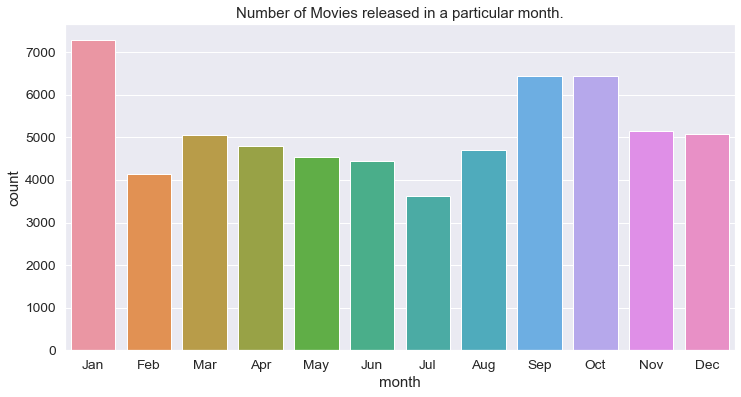

In [42]:
plt.figure(figsize=(12,6))
plt.title("Number of Movies released in a particular month.")
sns.countplot(x='month', data=df, order=month_order)

It appears that January is the most popular month when it comes to movie releases. In Hollywood circles, this is also known as the the dump month when sub par movies are released by the dozen

In which months do bockbuster movies tend to release? To answer this question, we will consider all movies that have made in excess of 100 million dollars and calculate the average gross for each month.

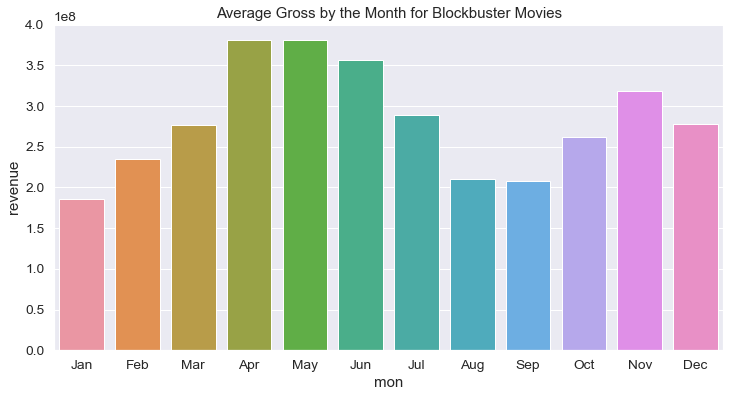

In [43]:
month_mean = pd.DataFrame(df[df['revenue'] > 1e8].groupby('month')['revenue'].mean())
month_mean['mon'] = month_mean.index
plt.figure(figsize=(12,6))
plt.title("Average Gross by the Month for Blockbuster Movies")
sns.barplot(x='mon', y='revenue', data=month_mean, order=month_order)

We see that the months of <b>April, May and June</b> have the highest average gross among high grossing movies. This can be attributed to the fact that blockbuster movies are usually released in the summer when the kids are out of school and the parents are on vacation and therefore, the audience is more likely to spend their disposable income on entertainment.

Let us now have a look at the most popular days as we did for months.

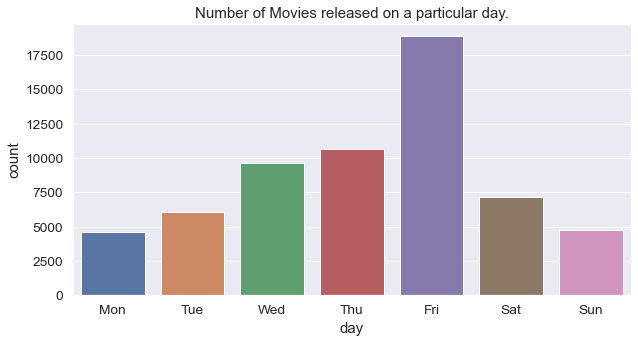

In [44]:
plt.figure(figsize=(10,5))
plt.title("Number of Movies released on a particular day.")
sns.countplot(x='day', data=df, order=day_order)

<b>Friday</b> is clearly the most popular day for movie releases. This is understandable considering the fact that it usually denotes the beginning of the weekend

### Number of movies by the year

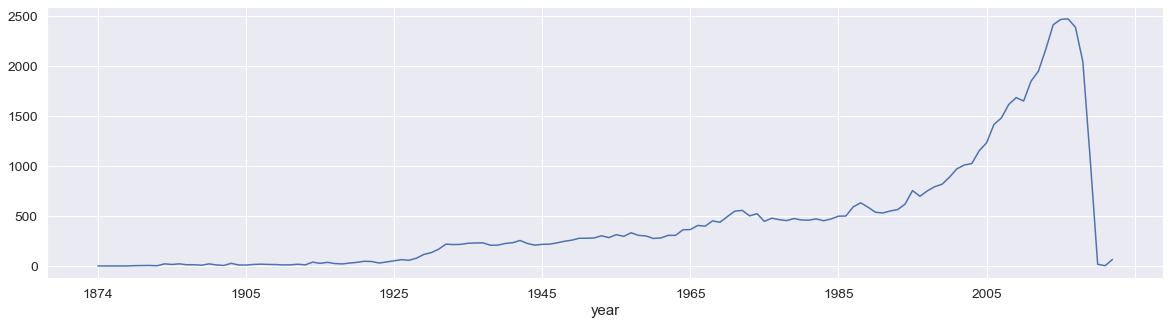

In [45]:
year_count = df.groupby('year')['title'].count()
plt.figure(figsize=(20,5))
year_count.plot()


We notice that there is a sharp rise in the number of movies starting the 1990s decade. However, we will not look too much into this as it is entirely possible that recent movies were oversampled for the purposes of this dataset.

### Spoken Languages

Does the number of spoken languages influence the success of a movie? To do this, we will convert our spoken_languages feature to a numeric feature denoting the number of languages spoken in that film.

In [46]:
df['spoken_languages'] = df['spoken_languages'].fillna('[]').apply(ast.literal_eval)
df['spoken_languages']=df['spoken_languages'].apply(lambda x: len(x) if isinstance(x, list) else np.nan)

In [47]:
df['spoken_languages'].value_counts()

1     47308
2      7402
0      3727
3      2220
4       750
5       241
6        74
7        20
8        11
9         7
10        4
12        2
14        1
13        1
Name: spoken_languages, dtype: int64

Most movies have just one language spoken in the entire duration of the film. <b>14</b> is the higest number of languages spoken in a film. 

Let us take a look at all the films with more than 10 spoken languages.

In [48]:
df[df['spoken_languages']>=10][['title','year','spoken_languages']].sort_values('spoken_languages',ascending=False)

,title,year,spoken_languages
59027,Train Station,2015,14
35645,The Testaments,2000,13
13682,To Each His Own Cinema,2007,12
43181,City Life,1990,12
8827,The Adventures of Picasso,1978,10
13971,2012,2009,10
47127,The Life,2004,10
48662,Human Flow,2017,10


The movie with the most number of languages, <b>Train Station</b>

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


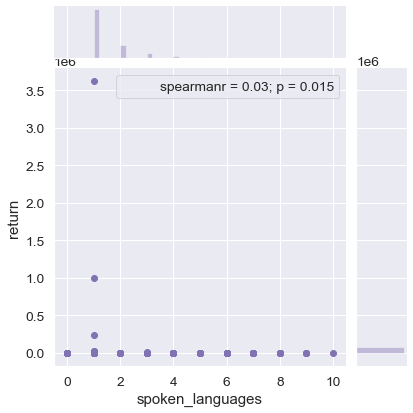

In [49]:
sns.jointplot(x="spoken_languages", y="return", data=df, stat_func=stats.spearmanr, color="m")

The Spearman Coefficient is <b>0.03</b> indicating no correlation between the two quantities.

## Runtime

In [50]:
df['runtime'].describe()

count    61591.000000
mean        92.422075
std         33.387936
min          0.000000
25%         84.000000
50%         94.000000
75%        105.000000
max        902.000000
Name: runtime, dtype: float64

In [51]:
df['runtime']=df['runtime'].astype('float')

### Shortest Movie

In [52]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime').head(10)

,runtime,title,year
37231,1.0,The Ghost Train,1903
37225,1.0,Eiffel Tower from Trocadero Palace,1900
37226,1.0,Palace of Electricity,1900
27427,1.0,Comic Face,1897
27428,1.0,Dickson Greeting,1891
43660,1.0,Demolition of a Wall,1896
37227,1.0,Champs de Mars,1900
46758,1.0,Battle of Mafeking,1900
43661,1.0,"Fifth Avenue, New York",1897
43659,1.0,Panorama du grand Canal pris d'un bateau,1896


We see that every movie in this list filmed in the late 1890s and the beginning of the 20th century. All these movies were one minute long.

### Longest Movie

In [53]:
df[df['runtime'] > 0][['runtime', 'title', 'year']].sort_values('runtime', ascending=False).head(10)

,runtime,title,year
13394,902.0,Berlin Alexanderplatz,1980
26562,900.0,The Story of Film: An Odyssey,2011
58554,803.0,La Flor,2019
52777,743.0,Out 1,1971
52294,663.0,Mikhaylo Lomonosov,1986
59233,644.0,Civilisation,1969
36634,644.0,Liquidation,2007
52227,608.0,Kingdom Hospital,2004
34933,585.0,The Untold History Of The United States,2012
52727,584.0,Criminal Justice,2008


### RelationShip between Budget and Revenue

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


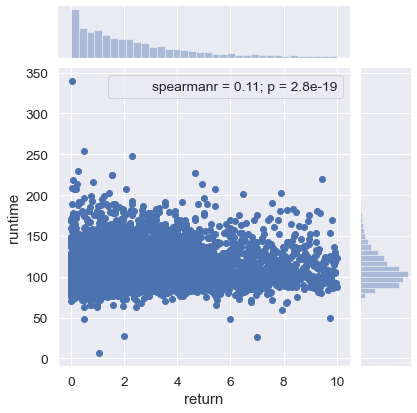

In [54]:
df_mat = df[(df['return'].notnull()) & (df['runtime'] > 0) & (df['return'] < 10)]
sns.jointplot('return', 'runtime', data=df_mat,stat_func=stats.spearmanr)
plt.show()

there is no much of a relationship between two.

However, I have a feeling this might not be the case with duration and budget. A longer movie should entail a higher budget. Let us find out if this is really the case.

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


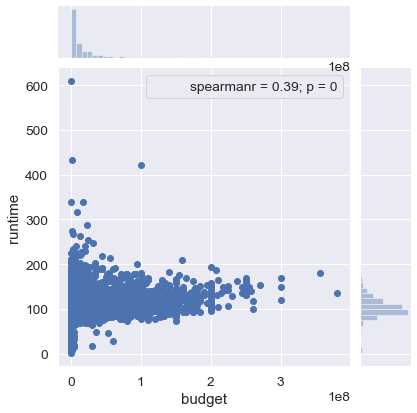

In [55]:
df_mat = df[(df['budget'].notnull()) & (df['runtime'] > 0)]
sns.jointplot('budget', 'runtime', data=df_mat,stat_func=stats.spearmanr)
plt.show()

The two quantities have a much weaker correlation than I had expected. In retrospect, the genre of the movie tends to have a much greater impact on budget. A 3 hour art film will cost significantly lesser than a 90 minute Sci-Fi movie.


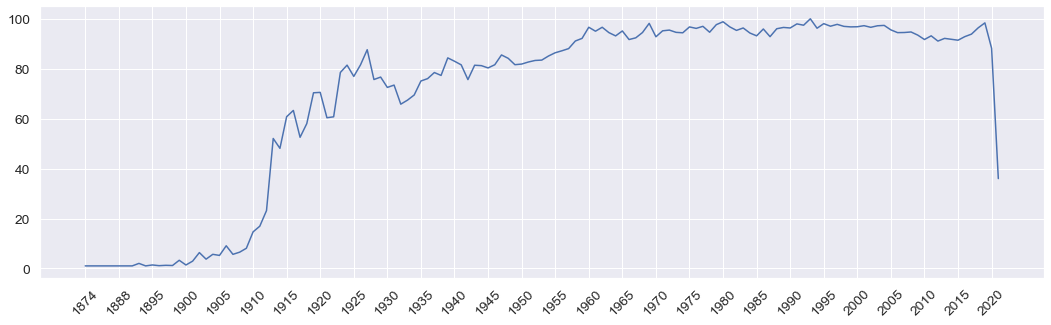

In [56]:
plt.figure(figsize=(18,5))
year_runtime = df[df['year'] != 'NaT'].groupby('year')['runtime'].mean()
plt.plot(year_runtime.index, year_runtime)
plt.xticks(year_runtime.index[::5],rotation=45)
plt.show()

We notice that films started hitting the 60 minute mark as early as 1914. Starting 1924, films started having the traiditonal 90 minute duration and has remained more or less constant ever since.

## Budget

In [57]:
df['budget'].describe()

count    1.118900e+04
mean     1.972252e+07
std      3.348113e+07
min      1.000000e+00
25%      1.500000e+06
50%      6.965576e+06
75%      2.300000e+07
max      3.800000e+08
Name: budget, dtype: float64

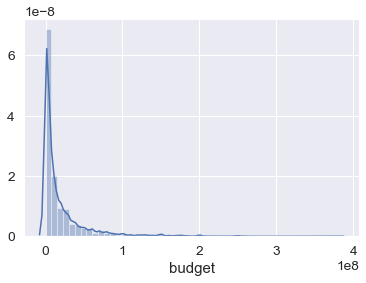

In [58]:
sns.distplot(df[df['budget'].notnull()]['budget'])

The distribution of movie budgets shows an exponential decay. More than 75% of the movies have a budget smaller than 25 million dollars.

In [59]:
df[df['budget'].notnull()][['title','budget','revenue','return','year']].sort_values('budget',ascending=False).head(10)

,title,budget,revenue,return,year
16395,Pirates of the Caribbean: On Stranger Tides,380000000.0,1.045714e+09,2.751878,2011
24873,Avengers: Endgame,356000000.0,2.797801e+09,7.858990,2019
24872,Avengers: Infinity War,300000000.0,2.046240e+09,6.820799,2018
24866,Justice League,300000000.0,6.579243e+08,2.193081,2017
11617,Pirates of the Caribbean: At World's End,300000000.0,9.610000e+08,3.203333,2007
10906,Superman Returns,270000000.0,3.910812e+08,1.448449,2006
15503,Tangled,260000000.0,5.924617e+08,2.278699,2010
59768,The Lion King,260000000.0,1.656943e+09,6.372859,2019
11572,Spider-Man 3,258000000.0,8.908716e+08,3.452991,2007
19823,The Lone Ranger,255000000.0,8.928991e+07,0.350157,2013


Two Pirates of the Carribean films occupy the top spot in this list and 5th spot with a staggering budget of over 300 million dollars. In between superhero movies collections Avengers: Endgame, Avengers:infinity war, Justice league were present

C:\Users\kiran\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


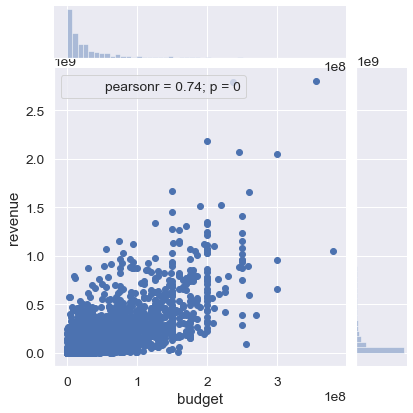

In [60]:
sns.jointplot(x='budget',y='revenue',data=df[df['return'].notnull()],stat_func=stats.pearsonr)

The pearson r value of 0.73 between the two quantities indicates a very strong correlation.

## Revenue

The final numeric feature we will explore is the revenue. The revenue is probably the most important numeric quantity associated with a movie. We will try to predict the revenue for movies given a set of features in a later section. The treatment of revenue will be very similar to that of budget and we will once again begin by studying the summary statistics.

In [61]:
df['revenue'].describe()

count    9.622000e+03
mean     6.317204e+07
std      1.479007e+08
min      1.000000e+00
25%      1.739726e+06
50%      1.294184e+07
75%      5.591090e+07
max      2.797801e+09
Name: revenue, dtype: float64

The mean gross of a movie is <b>63.1 million dollars</b> whereas the median gross is much lower at <b>12.9 million dollars</b>, suggesting the skewed nature of revenue. The lowest revenue generated by a movie is just 1 dollar whereas the highest grossing movie of all time has raked in an astonishing <b>2.78 billion dollars</b>.

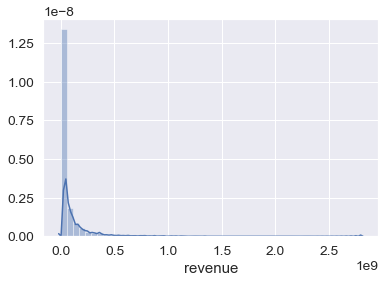

In [62]:
sns.distplot(df[df['revenue'].notnull()]['revenue'])


The distribution of revenue undergoes exponential decay just like budget. We also found that the two quantities were strongly correlated. Let us now take a look at the highest and least grossing movies of all time.

### Highest Grossing Film of all time

In [63]:
gross_top = df[['title', 'budget', 'revenue', 'year']].sort_values('revenue', ascending=False).head(10)
pd.set_option('display.max_colwidth', 100)
HTML(gross_top.to_html(escape=False))

,title,budget,revenue,year
24873,Avengers: Endgame,356000000.0,2.797801e+09,2019
14088,Avatar,237000000.0,2.787965e+09,2009
1704,Titanic,200000000.0,2.187464e+09,1997
24861,Star Wars: The Force Awakens,245000000.0,2.068224e+09,2015
24872,Avengers: Infinity War,300000000.0,2.046240e+09,2018
23082,Jurassic World,150000000.0,1.671713e+09,2015
59768,The Lion King,260000000.0,1.656943e+09,2019
17019,The Avengers,220000000.0,1.519558e+09,2012
27746,Furious 7,190000000.0,1.515048e+09,2015
61164,Frozen II,150000000.0,1.450027e+09,2019


In [64]:
pd.set_option('display.max_colwidth', 50)

<b> Avengers:Endgame</b> is the top grossing film, if you remember it is top second highest budgeted film

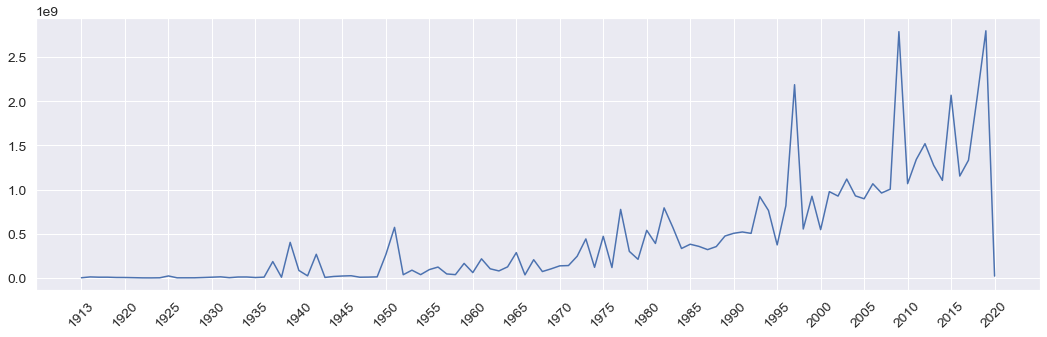

In [65]:
plt.figure(figsize=(18,5))
year_revenue = df[(df['revenue'].notnull()) & (df['year'] != 'NaT')].groupby('year')['revenue'].max()
plt.plot(year_revenue.index, year_revenue)
plt.xticks(year_revenue.index[::5],rotation=45)
plt.show()

As can be seen from the figure, the maximum gross has steadily risen over the years. The world of movies broke the 1 billion dollar mark in 1997 with the release of Titanic. It took another 12 years to break the 2 billion dollar mark with Avatar. Both these movies were directed by James Cameron.

## Returns

### Most successful Movies

In [66]:
df[(df['return'].notnull()) & (df['budget'] > 5e6)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return', ascending=False).head(10)

,title,budget,revenue,return,year
1125,E.T. the Extra-Terrestrial,10500000.0,792965326.0,75.520507,1982
317,Star Wars,11000000.0,775398007.0,70.490728,1977
1403,Jaws,7000000.0,470653000.0,67.236143,1975
1954,The Exorcist,8000000.0,441306145.0,55.163268,1973
412,Four Weddings and a Funeral,6000000.0,254700832.0,42.450139,1994
895,The Godfather,6000000.0,245066411.0,40.844402,1972
22244,Annabelle,6500000.0,257047661.0,39.545794,2014
4554,Look Who's Talking,7500000.0,296000000.0,39.466667,1989
1116,Dirty Dancing,6000000.0,213893795.0,35.648966,1987
1067,The Sound of Music,8200000.0,286214286.0,34.904181,1965


### Worst Box office disasters

In [67]:
df[(df['return'].notnull()) & (df['budget'] > 5e6) & (df['revenue'] > 10000)][['title', 'budget', 'revenue', 'return', 'year']].sort_values('return').head(10)

,title,budget,revenue,return,year
10994,Chaos,20000000.0,10289.0,0.000514,2005
18099,5 Days of War,20000000.0,17479.0,0.000874,2011
30901,Accidental Love,26000000.0,24487.0,0.000942,2015
23800,Foodfight!,65000000.0,73706.0,0.001134,2012
39415,Term Life,16500000.0,21256.0,0.001288,2016
18466,Laurence Anyways,9500000.0,12250.0,0.001289,2012
11815,The Good Night,15000000.0,20380.0,0.001359,2007
4028,Cherry 2000,10000000.0,14000.0,0.001400,1987
20508,Twice Born,13000000.0,18295.0,0.001407,2012
5712,All The Queen's Men,15000000.0,23000.0,0.001533,2001


In [68]:
df['year'] = df['year'].replace('NaT', np.nan)

In [69]:
df['year'] = df['year'].apply(clean_numeric)

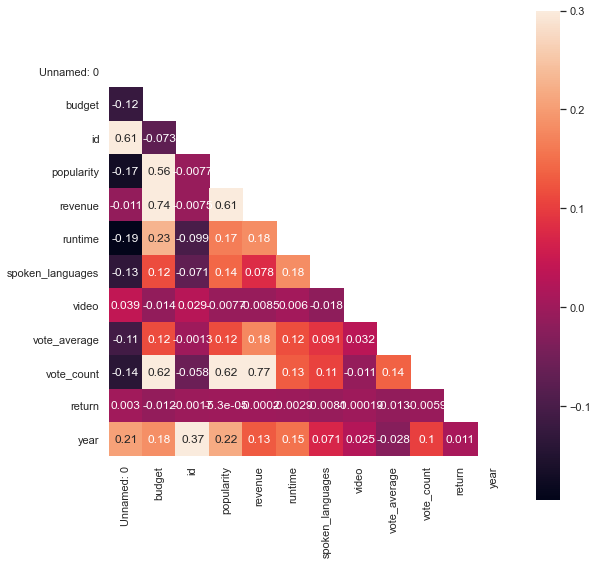

In [70]:
sns.set(font_scale=1)
corr = df.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
with sns.axes_style("white"):
    plt.figure(figsize=(9,9))
    ax = sns.heatmap(corr, mask=mask, vmax=.3, square=True, annot=True)

## Genres

In [71]:
df['genres'] = df['genres'].fillna('[]').apply(ast.literal_eval)
df['genres']=df['genres'].apply(lambda x: [i['name'] for i in x] if isinstance(x, list) else [])

In [72]:
s = df.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
s.name = 'genre'

C:\Users\kiran\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [73]:
gen_df = df.drop('genres', axis=1).join(s)

In [74]:
gen_df['genre'].value_counts().shape[0]

19

TMDB defines 19 different genres for our set of 68,000 movies. Let us now have a look at the most commonly occuring genres in movies.

In [75]:
pop_gen = pd.DataFrame(gen_df['genre'].value_counts()).reset_index()
pop_gen.columns = ['genre', 'movies']
pop_gen.head(10)

,genre,movies
0,Drama,27339
1,Comedy,18147
2,Thriller,9769
3,Romance,9005
4,Action,8159
5,Horror,6435
6,Crime,6001
7,Documentary,5766
8,Adventure,4544
9,Science Fiction,3877


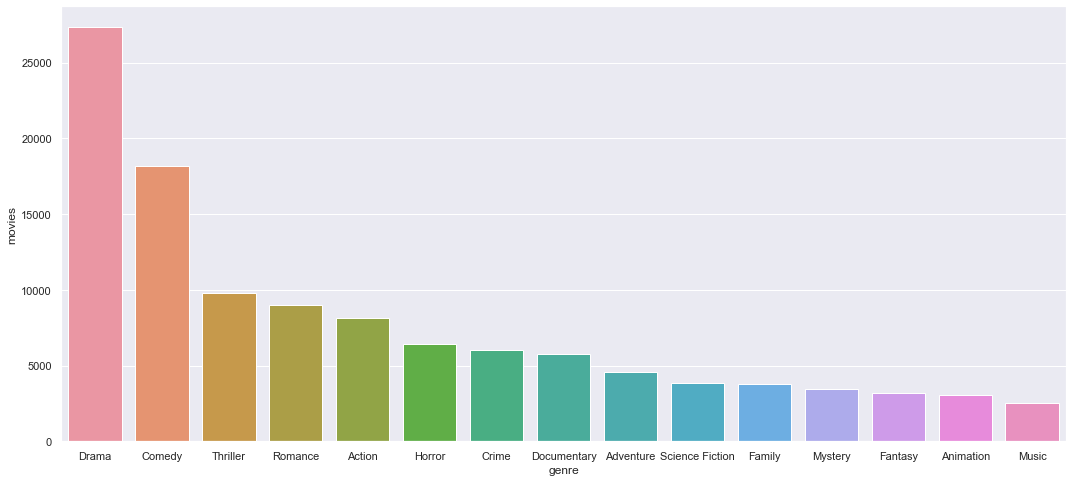

In [76]:
plt.figure(figsize=(18,8))
sns.barplot(x='genre', y='movies', data=pop_gen.head(15))
plt.show()

<b>Drama</b> is the most commonly occurring genre with almost half the movies identifying itself as a drama film. Comedy comes in at a distant second with 25% of the movies having adequate doses of humor. Other major genres represented in the top 10 are Action, Horror, Crime, Mystery, Science Fiction, Animation and Fantasy.

The next question I want to answer is the trends in the share of genres of movies across the world. Has the demand for Science Fiction movies increased? Do certain years have a disproportionate share of Animation Movies? Let's find out!

We will only be looking at trends starting 2000. We will consider only those themes that appear in the top 15 most popular genres. We will exclude Documentaries, Family and Foreign Movies from our analysis.

In [77]:
genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Adventure', 'Science Fiction', 'Mystery', 'Fantasy', 'Mystery', 'Animation']

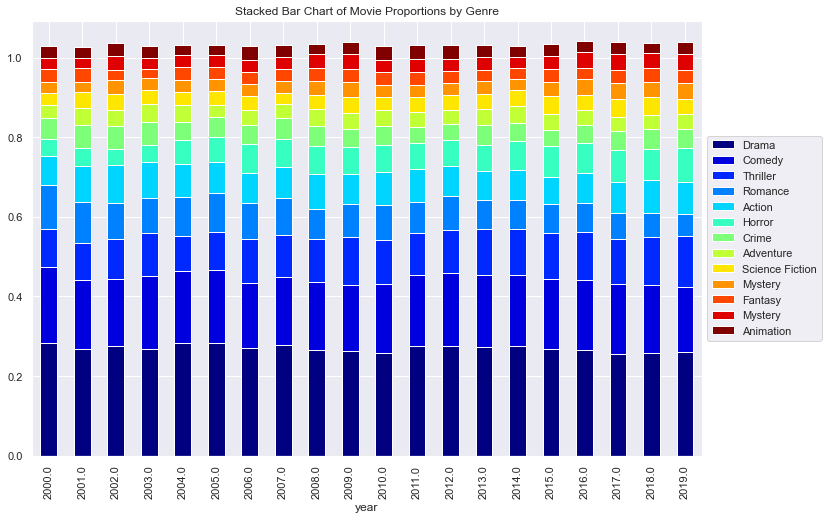

In [78]:
pop_gen_movies = gen_df[(gen_df['genre'].isin(genres)) & (gen_df['year'] >= 2000) & (gen_df['year'] <= 2019)]
ctab = pd.crosstab([pop_gen_movies['year']], pop_gen_movies['genre']).apply(lambda x: x/x.sum(), axis=1)
ctab[genres].plot(kind='bar', stacked=True, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Stacked Bar Chart of Movie Proportions by Genre")
plt.show()

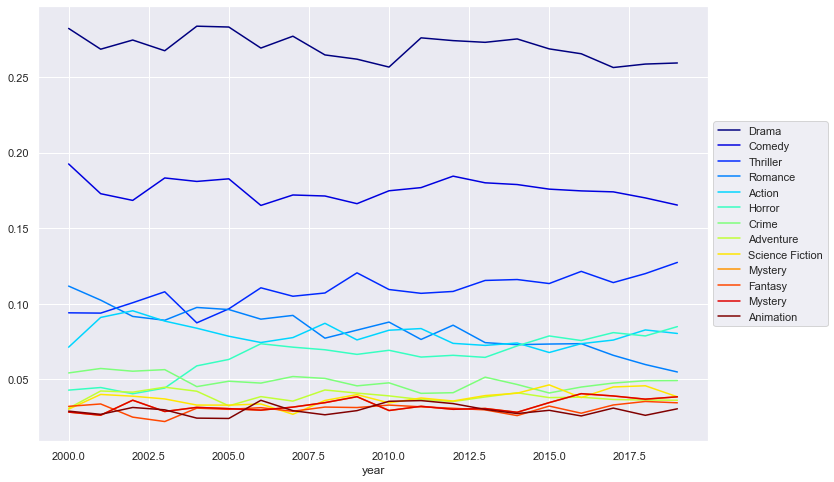

In [79]:
ctab[genres].plot(kind='line', stacked=False, colormap='jet', figsize=(12,8)).legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

The proportion of movies of each genre has remained fairly constant since the beginning of this century except for Drama. The proportion of drama films has fallen by over 5%. Thriller movies have enjoyed a slight increase in their share.

One question that I have always had is that if some genres are particularly more successful than others. For example, we should expect Science Fiction and Fantasy Movies to bring in more revenue than other genres but when normalized with their budget, do they prove to be as successful? We will visualize two violin plots to answer this question. One will be genres versus the revenue while the other will be versus returns.

In [80]:
violin_genres = ['Drama', 'Comedy', 'Thriller', 'Romance', 'Action', 'Horror', 'Crime', 'Science Fiction', 'Fantasy', 'Animation']
violin_movies = gen_df[(gen_df['genre'].isin(violin_genres))]

<Figure size 1296x576 with 0 Axes>

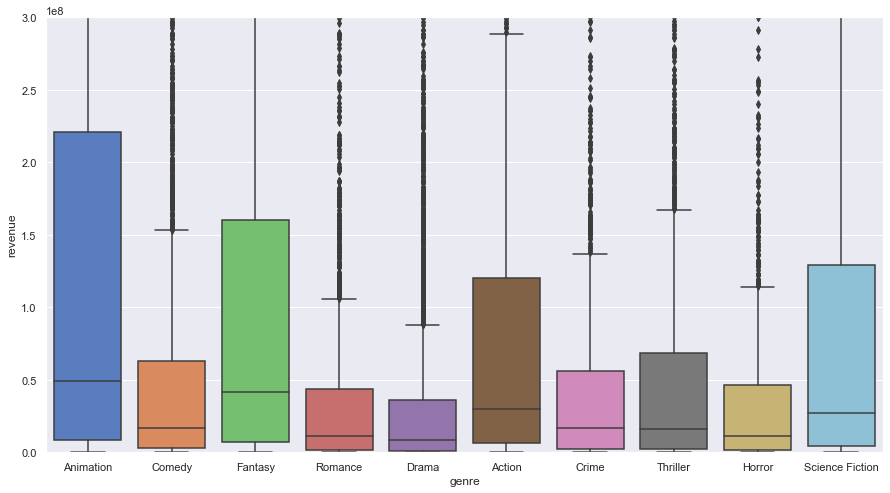

In [81]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='revenue', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 3e8])
plt.show()

<b>Animation</b> movies has the largest 25-75 range as well as the median revenue among all the genres plotted. <b>Fantasy and Science Fiction</b> have the second and third highest median revenue respectively.

<Figure size 1296x576 with 0 Axes>

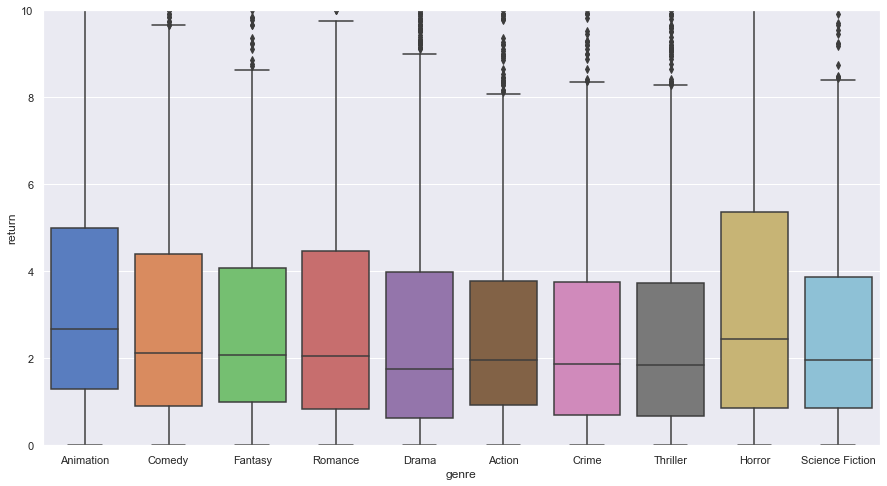

In [82]:
plt.figure(figsize=(18,8))
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(15, 8))
sns.boxplot(x='genre', y='return', data=violin_movies, palette="muted", ax =ax)
ax.set_ylim([0, 10])
plt.show()

From the boxplot, it seems like <b>Animation Movies</b> tend to yield the highest returns on average. <b>Horror Movies</b> also tend to be a good bet. This is partially due to the nature of Horror movies being low budget compared to Fantasy Movies but being capable of generating very high revenues relative to its budget.

## cast and crew

In [83]:
cast_df=pd.read_csv('../data/movies_metadata_castncrew.csv')

C:\Users\kiran\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (24) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Actors with Highest total Revenue

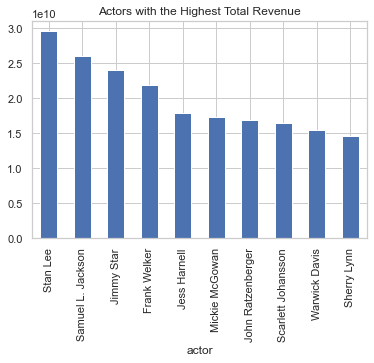

In [84]:
sns.set_style('whitegrid')
plt.title('Actors with the Highest Total Revenue')
cast_df.groupby('actor')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

## Directors with Highest total Revenue

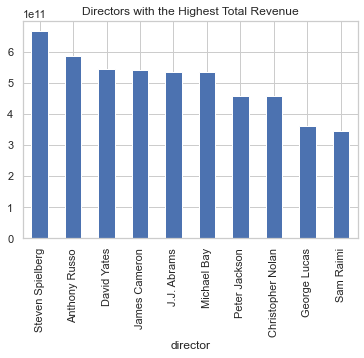

In [85]:
plt.title('Directors with the Highest Total Revenue')
cast_df.groupby('director')['revenue'].sum().sort_values(ascending=False).head(10).plot(kind='bar')
plt.show()

In [86]:
actor_list = cast_df.groupby('actor')['revenue'].count().sort_values(ascending=False)
actor_list = list(actor_list[actor_list >= 5].index)
director_list = cast_df.groupby('director')['revenue'].count().sort_values(ascending=False)
director_list = list(director_list[director_list >= 5].index)

### Most successful Actor

In [87]:
success_df = cast_df[(cast_df['return'].notnull()) & (cast_df['revenue'] > 1e7) & (cast_df['actor'].isin(actor_list))]
pd.DataFrame(success_df.groupby('actor')['return'].mean().sort_values(ascending=False).head(10))


,return
actor,
Rhys Wakefield,1.206781e+06
Christopher James Baker,7.240656e+05
Dan Wyllie,7.240637e+05
Richard Roxburgh,4.525411e+05
Ioan Gruffudd,4.022603e+05
Pedro Casablanc,1.201567e+05
Julián López,8.010487e+04
Maribel Verdú,6.009010e+04
Katie Featherston,2.607307e+03


Rhys Wakefield is an Australian actor and director. Wakefield starred in season 3 of HBO's True Detective as Freddy Burns after starting out on the Australian TV series Home and Away where he starred in 363 episodes

### Most successful Director

In [88]:
success_df = cast_df[(cast_df['return'].notnull()) & (cast_df['revenue'] > 1e7) & (cast_df['director'].isin(actor_list))]
pd.DataFrame(success_df.groupby('director')['return'].mean().sort_values(ascending=False).head(10))


,return
director,
Sidney Poitier,168.571429
Melvin Van Peebles,101.333333
Richard C. Sarafian,55.589466
Alex Kendrick,48.228214
Jordan Peele,39.156514
George Lucas,38.681170
Luca Bercovici,35.000000
Orson Welles,27.649074
Karan Johar,26.809384


Sidney Poitier KBE is a Bahamian-American actor, film director, and ambassador. In 1964 Poitier became the first Black male and Afro-Bahamian actor to win an Academy Award for Best Actor

In [90]:
df1=df.merge(cast_df,on='id')

In [91]:
df1.to_csv('../data/eda.csv')